In [248]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
import json

from sklearn.model_selection import (
    train_test_split, cross_val_score, ShuffleSplit, GridSearchCV)
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA

from xgboost import XGBRegressor

In [249]:
df = pd.read_csv('/home/akeemlag/Downloads/car_price_prediction.csv')

## EXPLORATORY ANALYSIS

In [250]:
df.head(10)

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4
5,45802912,39493,891,HYUNDAI,Santa FE,2016,Jeep,Yes,Diesel,2,160931 km,4.0,Automatic,Front,04-May,Left wheel,White,4
6,45656768,1803,761,TOYOTA,Prius,2010,Hatchback,Yes,Hybrid,1.8,258909 km,4.0,Automatic,Front,04-May,Left wheel,White,12
7,45816158,549,751,HYUNDAI,Sonata,2013,Sedan,Yes,Petrol,2.4,216118 km,4.0,Automatic,Front,04-May,Left wheel,Grey,12
8,45641395,1098,394,TOYOTA,Camry,2014,Sedan,Yes,Hybrid,2.5,398069 km,4.0,Automatic,Front,04-May,Left wheel,Black,12
9,45756839,26657,-,LEXUS,RX 350,2007,Jeep,Yes,Petrol,3.5,128500 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12


In [251]:
print(df.shape)
df.info()

(19237, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  object 
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod. year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather interior  19237 non-null  object 
 8   Fuel type         19237 non-null  object 
 9   Engine volume     19237 non-null  object 
 10  Mileage           19237 non-null  object 
 11  Cylinders         19237 non-null  float64
 12  Gear box type     19237 non-null  object 
 13  Drive wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color             19237 non-

In [252]:
df.describe()

,ID,Price,Prod. year,Cylinders,Airbags
count,1.923700e+04,1.923700e+04,19237.000000,19237.000000,19237.000000
mean,4.557654e+07,1.855593e+04,2010.912824,4.582991,6.582627
std,9.365914e+05,1.905813e+05,5.668673,1.199933,4.320168
min,2.074688e+07,1.000000e+00,1939.000000,1.000000,0.000000
25%,4.569837e+07,5.331000e+03,2009.000000,4.000000,4.000000
50%,4.577231e+07,1.317200e+04,2012.000000,4.000000,6.000000
75%,4.580204e+07,2.207500e+04,2015.000000,4.000000,12.000000
max,4.581665e+07,2.630750e+07,2020.000000,16.000000,16.000000


In [253]:
df.duplicated().sum()

313

In [254]:
# Rename the cols for easy access
df.columns = df.columns.str.replace(' ', '_')

df.head()

,ID,Price,Levy,Manufacturer,Model,Prod._year,Category,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box_type,Drive_wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


There roughly 6000 rows with this kind of data that are not int and not null If we remove such humongous dataset, it will impact our ds training Proposition is to conver the remaining value to an int, calculate the mean per year and replace the  the - with the mean


In [255]:
def isInt(x):
    try:
        int(x)
    except:
        return None
    return int(x)

df.Mileage = df.Mileage.apply(lambda x: x.split(' ')[0])

In [256]:
# Convert Levy to int
cols_to_convert = ['Levy', 'Mileage', 'Cylinders']
for col in cols_to_convert:
    df[col] = df[col].apply(isInt)
    if df[col].isna().sum() > 0:
        df[col] = df[col].fillna(df[col].mean())
    df[col] = df[col].astype(int)

In [257]:
df.Engine_volume = df.Engine_volume.str.split(' ').str[0]
df.Engine_volume = df.Engine_volume.astype(float)

In [258]:
df.describe()

,ID,Price,Levy,Prod._year,Engine_volume,Mileage,Cylinders,Airbags
count,1.923700e+04,1.923700e+04,19237.000000,19237.000000,19237.000000,1.923700e+04,19237.000000,19237.000000
mean,4.557654e+07,1.855593e+04,906.584603,2010.912824,2.307990,1.532236e+06,4.582991,6.582627
std,9.365914e+05,1.905813e+05,385.733647,5.668673,0.877805,4.840387e+07,1.199933,4.320168
min,2.074688e+07,1.000000e+00,87.000000,1939.000000,0.000000,0.000000e+00,1.000000,0.000000
25%,4.569837e+07,5.331000e+03,730.000000,2009.000000,1.800000,7.013900e+04,4.000000,4.000000
50%,4.577231e+07,1.317200e+04,906.000000,2012.000000,2.000000,1.260000e+05,4.000000,6.000000
75%,4.580204e+07,2.207500e+04,917.000000,2015.000000,2.500000,1.888880e+05,4.000000,12.000000
max,4.581665e+07,2.630750e+07,11714.000000,2020.000000,20.000000,2.147484e+09,16.000000,16.000000


#### ::: From observation: Drop some features that serve no purpose

In [259]:
# Drop features that offer no trend or of no significant importance
# Not dropping engine vol or turbo_engine because this is a used car and it most business settings, that affects its resale value
# Drop the ID col and Doors cols ::: ID cols offers no value or trend, Doors col  is populated with the wrong data
# Dropping model as it has 1300+ categories and encoding label will cause dimensionality curse.¶

cols_to_drop = ['ID', 'Doors', 'Wheel', 'Drive_wheels', 'Color']
df = df.drop(cols_to_drop, axis=1)
df

,Price,Levy,Manufacturer,Model,Prod._year,Category,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box_type,Airbags
0,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005,6,Automatic,12
1,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3.0,192000,6,Tiptronic,8
2,8467,906,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000,4,Variator,2
3,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966,4,Automatic,0
4,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901,4,Automatic,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19232,8467,906,MERCEDES-BENZ,CLK 200,1999,Coupe,Yes,CNG,2.0,300000,4,Manual,5
19233,15681,831,HYUNDAI,Sonata,2011,Sedan,Yes,Petrol,2.4,161600,4,Tiptronic,8
19234,26108,836,HYUNDAI,Tucson,2010,Jeep,Yes,Diesel,2.0,116365,4,Automatic,4
19235,5331,1288,CHEVROLET,Captiva,2007,Jeep,Yes,Diesel,2.0,51258,4,Automatic,4


## ::: Visualization and Analysis

In [260]:
# Check if any cols contain values that are non int in the numerical cols
numerical_cols = df.select_dtypes(include=['int', 'float']).columns
print('numerical_cols: ', numerical_cols)
categorical_cols = df.select_dtypes(include=['object']).columns
print('categorical_cols: ',categorical_cols)

numerical_cols:  Index(['Price', 'Levy', 'Prod._year', 'Engine_volume', 'Mileage', 'Cylinders',
       'Airbags'],
      dtype='object')
categorical_cols:  Index(['Manufacturer', 'Model', 'Category', 'Leather_interior', 'Fuel_type',
       'Gear_box_type'],
      dtype='object')


#### Let's handle outliers

#### Before using IQR to remove analysis

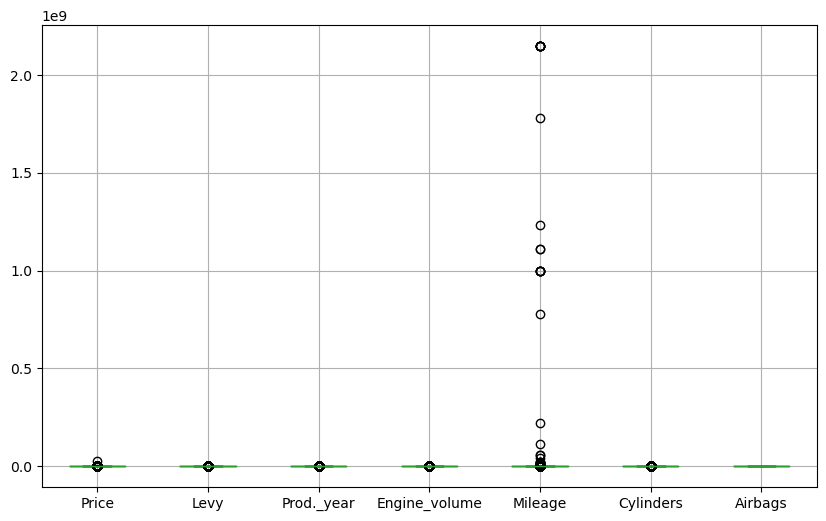

In [261]:
#Create a boc plot to visualize outliers in the numerical cols
numerical_data = df.select_dtypes(exclude=object)
numerical_data
cols = [col for col in numerical_data]
numerical_data.boxplot(figsize=(10,6), column=cols)
plt.show();

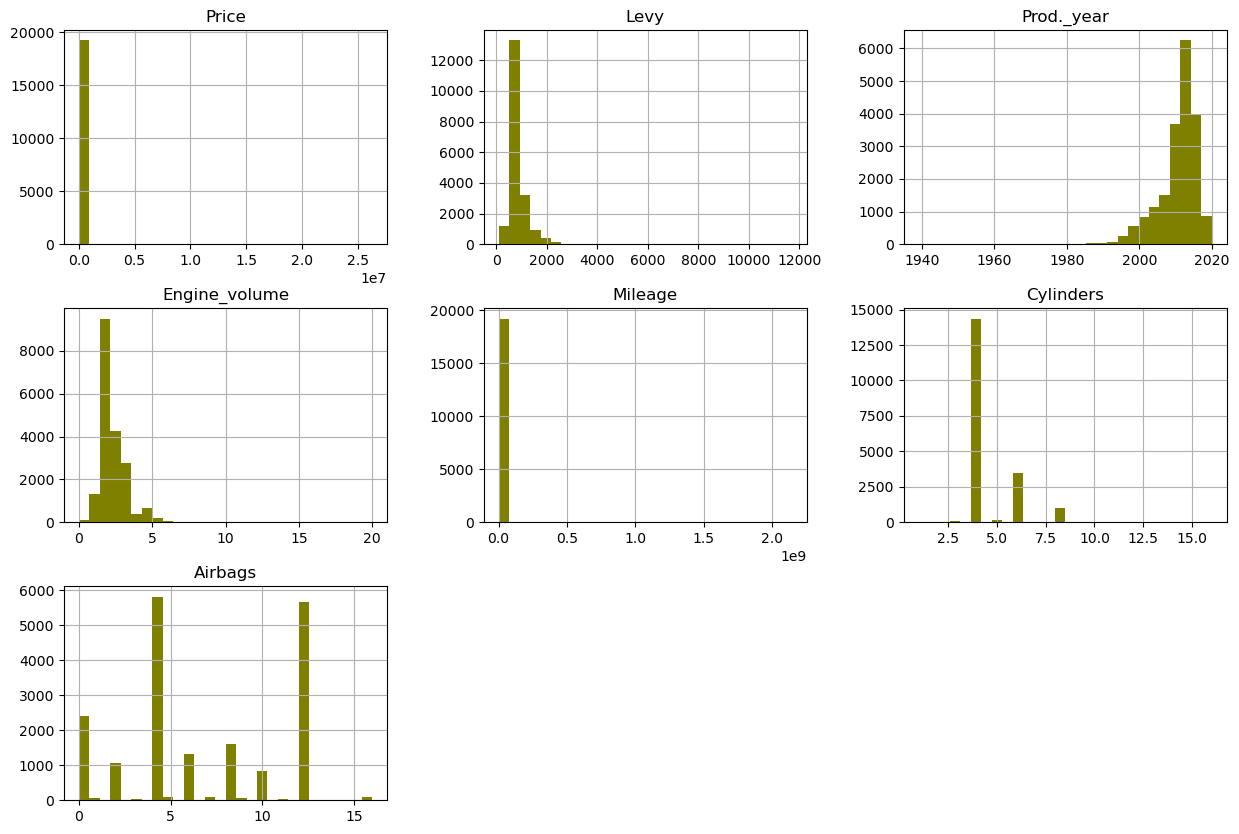

In [262]:
df.hist(bins = 28, figsize=(15, 10), color ='olive')
plt.show();

In [263]:
def get_and_remove_outliers_iqr(col_name, df):
    # Use quantile to reassign outliers
    lower_limit, upper_limit = df[col_name].quantile([0.1, 0.95])

    print(f'upper_limit: ', {upper_limit})
    print(f'lower_limit: ', {lower_limit})
    outliers = df[(df[col_name] > upper_limit) | (df[col_name] < lower_limit)]
    print(f'There are {outliers.shape[0]} outliers')
    df[col_name] = np.where(df[col_name] < lower_limit, lower_limit, df[col_name])
    df[col_name] = np.where(df[col_name] > upper_limit, upper_limit, df[col_name])
    return df

In [264]:
get_and_remove_outliers_iqr('Mileage', df)

upper_limit:  {320000.0}
lower_limit:  {25061.400000000005}
There are 2882 outliers


,Price,Levy,Manufacturer,Model,Prod._year,Category,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box_type,Airbags
0,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005.0,6,Automatic,12
1,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3.0,192000.0,6,Tiptronic,8
2,8467,906,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000.0,4,Variator,2
3,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966.0,4,Automatic,0
4,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901.0,4,Automatic,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19232,8467,906,MERCEDES-BENZ,CLK 200,1999,Coupe,Yes,CNG,2.0,300000.0,4,Manual,5
19233,15681,831,HYUNDAI,Sonata,2011,Sedan,Yes,Petrol,2.4,161600.0,4,Tiptronic,8
19234,26108,836,HYUNDAI,Tucson,2010,Jeep,Yes,Diesel,2.0,116365.0,4,Automatic,4
19235,5331,1288,CHEVROLET,Captiva,2007,Jeep,Yes,Diesel,2.0,51258.0,4,Automatic,4


In [265]:
get_and_remove_outliers_iqr(col_name='Price', df=df)

upper_limit:  {49459.0}
lower_limit:  {627.0}
There are 2810 outliers


,Price,Levy,Manufacturer,Model,Prod._year,Category,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box_type,Airbags
0,13328.0,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005.0,6,Automatic,12
1,16621.0,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3.0,192000.0,6,Tiptronic,8
2,8467.0,906,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000.0,4,Variator,2
3,3607.0,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966.0,4,Automatic,0
4,11726.0,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901.0,4,Automatic,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19232,8467.0,906,MERCEDES-BENZ,CLK 200,1999,Coupe,Yes,CNG,2.0,300000.0,4,Manual,5
19233,15681.0,831,HYUNDAI,Sonata,2011,Sedan,Yes,Petrol,2.4,161600.0,4,Tiptronic,8
19234,26108.0,836,HYUNDAI,Tucson,2010,Jeep,Yes,Diesel,2.0,116365.0,4,Automatic,4
19235,5331.0,1288,CHEVROLET,Captiva,2007,Jeep,Yes,Diesel,2.0,51258.0,4,Automatic,4


In [266]:
get_and_remove_outliers_iqr(col_name='Levy', df=df)

upper_limit:  {1537.0}
lower_limit:  {583.0}
There are 2785 outliers


,Price,Levy,Manufacturer,Model,Prod._year,Category,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box_type,Airbags
0,13328.0,1399.0,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005.0,6,Automatic,12
1,16621.0,1018.0,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3.0,192000.0,6,Tiptronic,8
2,8467.0,906.0,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000.0,4,Variator,2
3,3607.0,862.0,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966.0,4,Automatic,0
4,11726.0,583.0,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901.0,4,Automatic,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19232,8467.0,906.0,MERCEDES-BENZ,CLK 200,1999,Coupe,Yes,CNG,2.0,300000.0,4,Manual,5
19233,15681.0,831.0,HYUNDAI,Sonata,2011,Sedan,Yes,Petrol,2.4,161600.0,4,Tiptronic,8
19234,26108.0,836.0,HYUNDAI,Tucson,2010,Jeep,Yes,Diesel,2.0,116365.0,4,Automatic,4
19235,5331.0,1288.0,CHEVROLET,Captiva,2007,Jeep,Yes,Diesel,2.0,51258.0,4,Automatic,4


In [267]:
get_and_remove_outliers_iqr(col_name='Engine_volume', df=df)

upper_limit:  {4.0}
lower_limit:  {1.5}
There are 2344 outliers


,Price,Levy,Manufacturer,Model,Prod._year,Category,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box_type,Airbags
0,13328.0,1399.0,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005.0,6,Automatic,12
1,16621.0,1018.0,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3.0,192000.0,6,Tiptronic,8
2,8467.0,906.0,HONDA,FIT,2006,Hatchback,No,Petrol,1.5,200000.0,4,Variator,2
3,3607.0,862.0,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966.0,4,Automatic,0
4,11726.0,583.0,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.5,91901.0,4,Automatic,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19232,8467.0,906.0,MERCEDES-BENZ,CLK 200,1999,Coupe,Yes,CNG,2.0,300000.0,4,Manual,5
19233,15681.0,831.0,HYUNDAI,Sonata,2011,Sedan,Yes,Petrol,2.4,161600.0,4,Tiptronic,8
19234,26108.0,836.0,HYUNDAI,Tucson,2010,Jeep,Yes,Diesel,2.0,116365.0,4,Automatic,4
19235,5331.0,1288.0,CHEVROLET,Captiva,2007,Jeep,Yes,Diesel,2.0,51258.0,4,Automatic,4


#### After using IQR to remove analysis

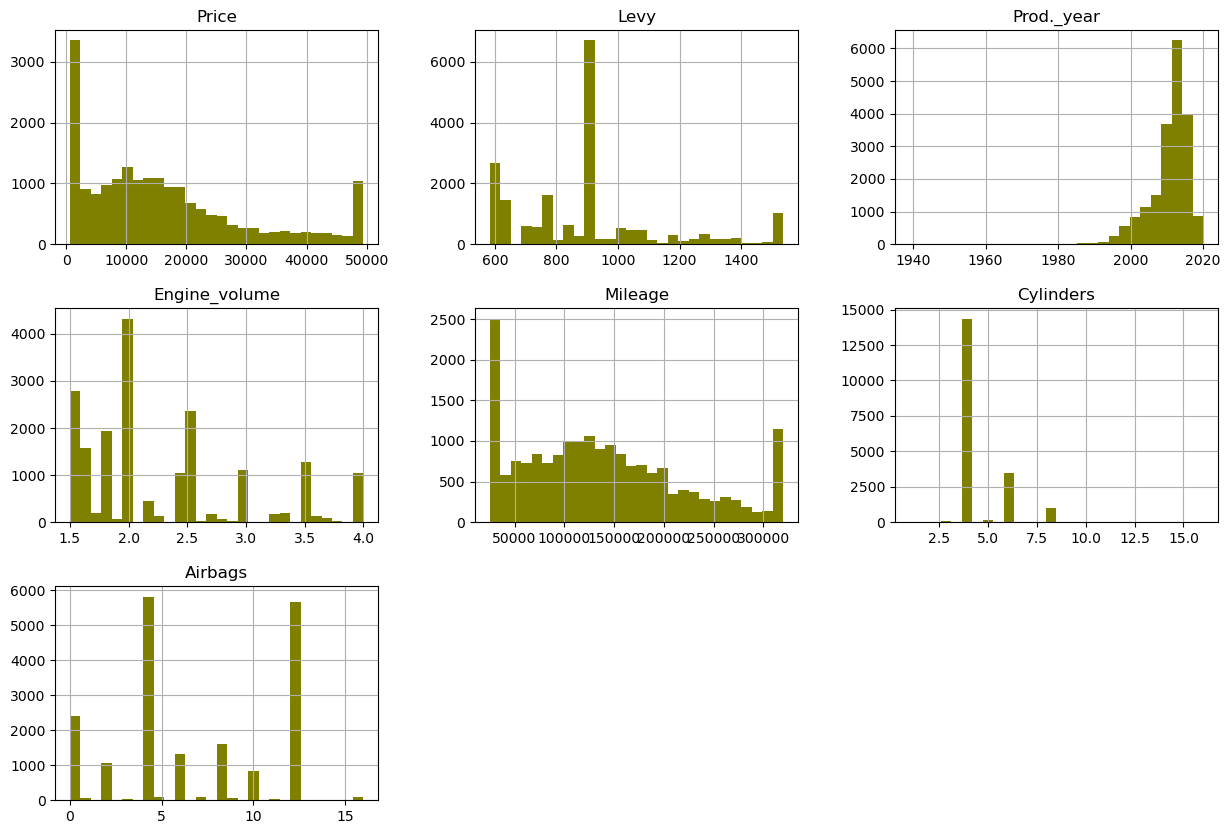

In [268]:
df.hist(bins = 28, figsize=(15, 10), color ='olive')
plt.show();

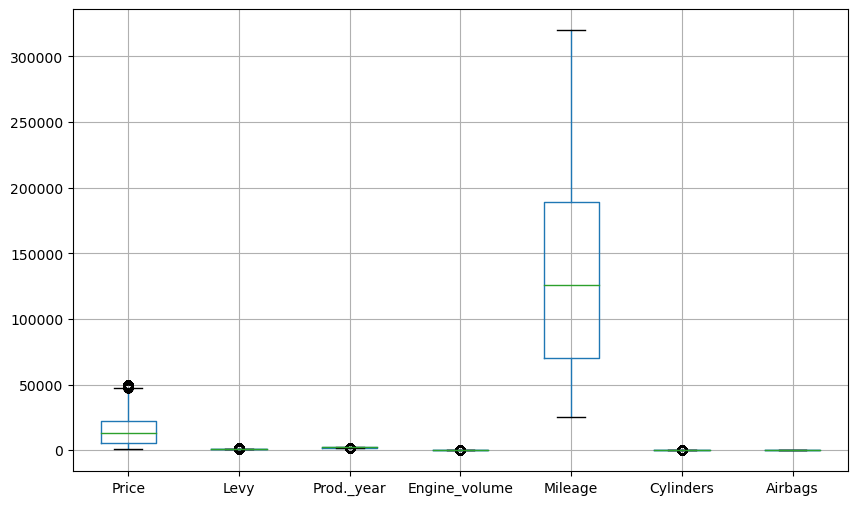

In [269]:
numerical_data = df.select_dtypes(exclude=object)
numerical_data
cols = [col for col in numerical_data]
numerical_data.boxplot(figsize=(10,6), column=cols)
plt.show();

In [270]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             19237 non-null  float64
 1   Levy              19237 non-null  float64
 2   Manufacturer      19237 non-null  object 
 3   Model             19237 non-null  object 
 4   Prod._year        19237 non-null  int64  
 5   Category          19237 non-null  object 
 6   Leather_interior  19237 non-null  object 
 7   Fuel_type         19237 non-null  object 
 8   Engine_volume     19237 non-null  float64
 9   Mileage           19237 non-null  float64
 10  Cylinders         19237 non-null  int64  
 11  Gear_box_type     19237 non-null  object 
 12  Airbags           19237 non-null  int64  
dtypes: float64(4), int64(3), object(6)
memory usage: 1.9+ MB


#### Categorical features visualization for understanding

<Figure size 2000x1000 with 0 Axes>

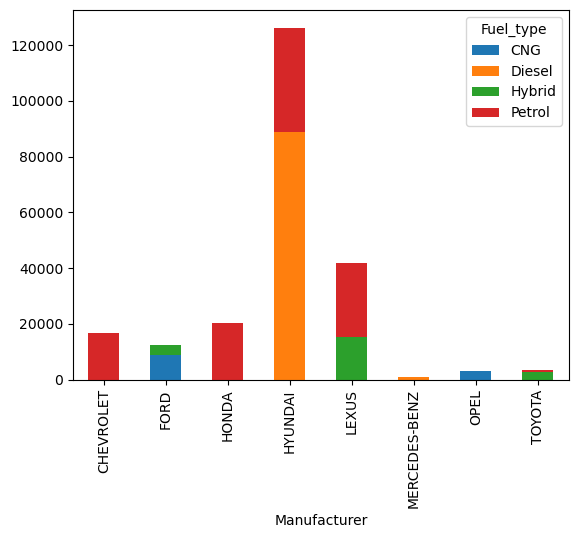

In [271]:
plt.figure(figsize=(20,10))
group_df = df.copy()
group_df = group_df.iloc[:20]
pivot_df = group_df.pivot_table(index='Manufacturer', columns='Fuel_type', values='Price', aggfunc='sum')

# Plotting the stacked bar plot
pivot_df.plot(kind='bar', stacked=True)
plt.show();

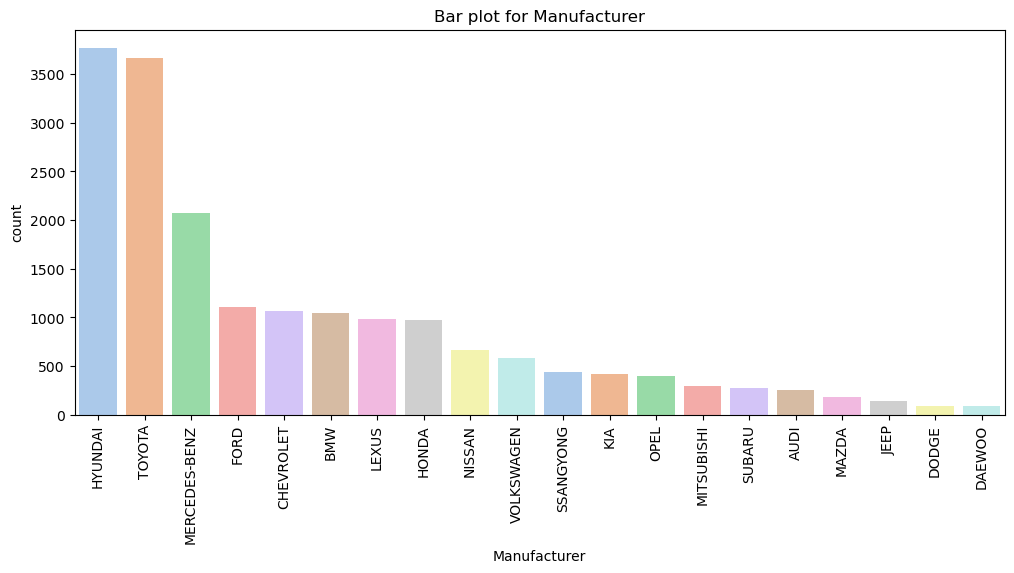

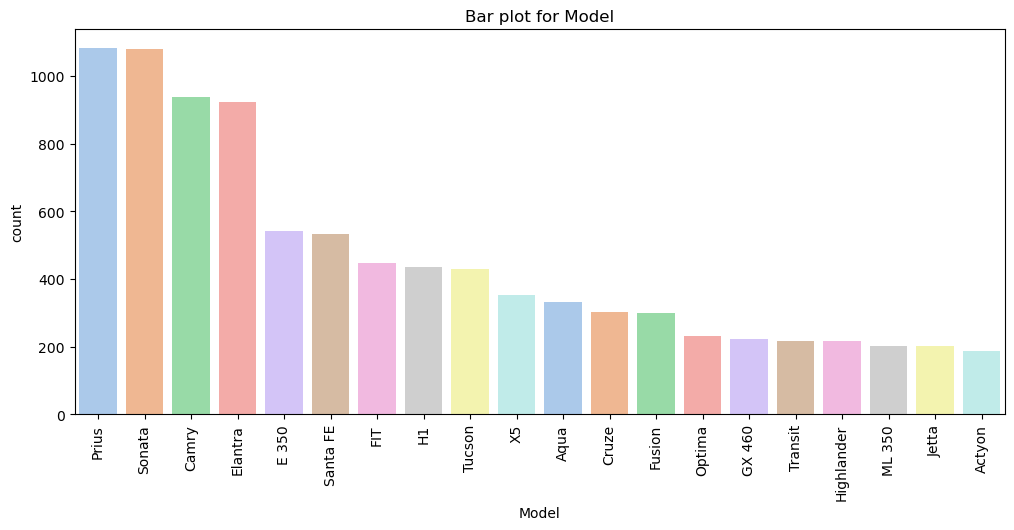

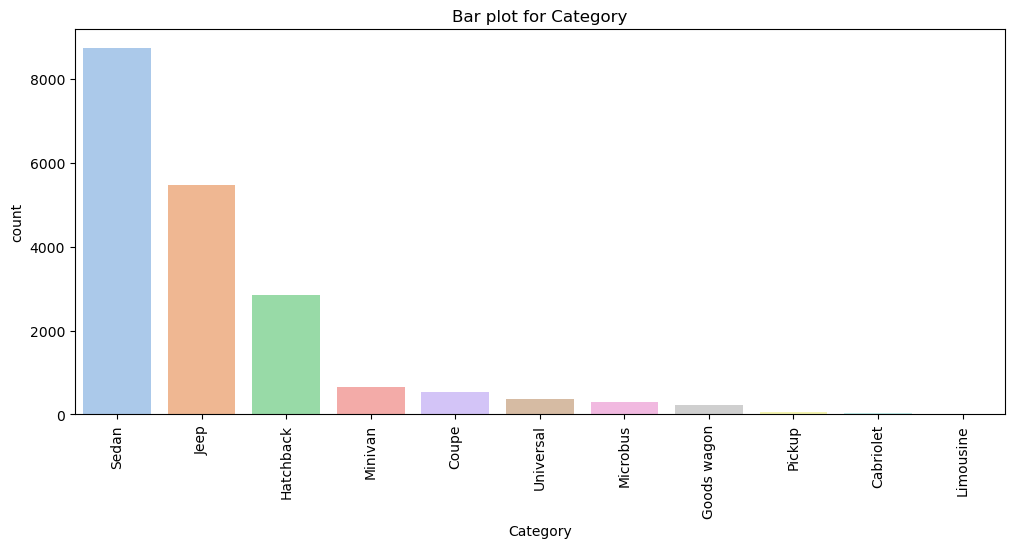

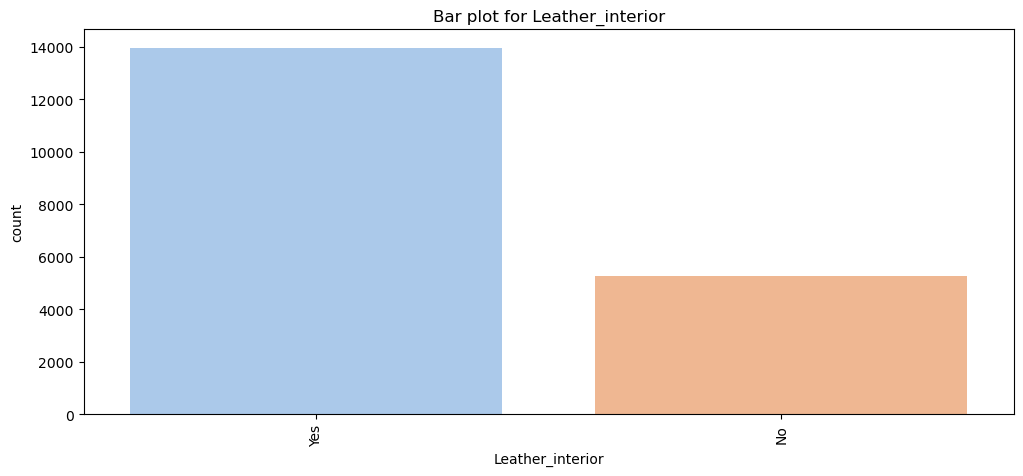

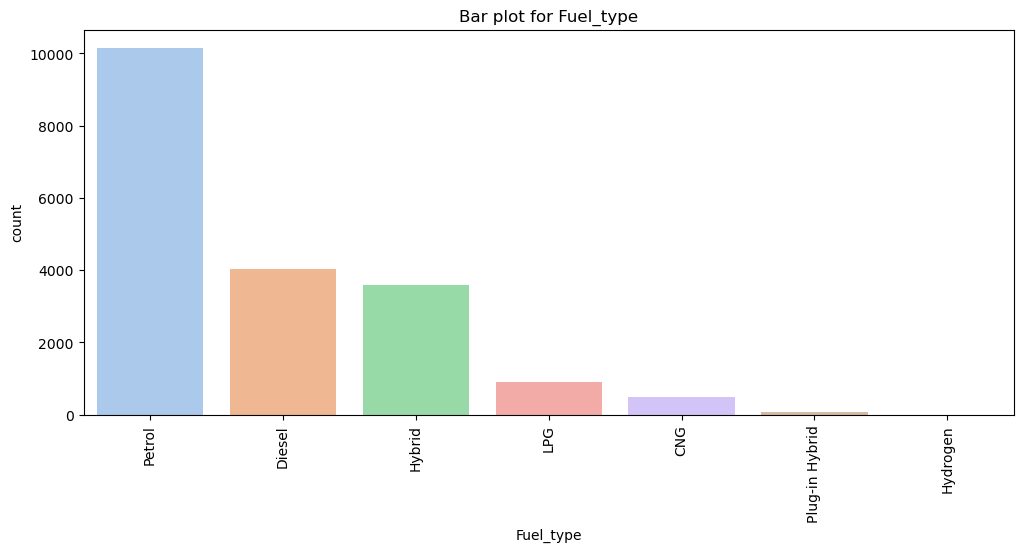

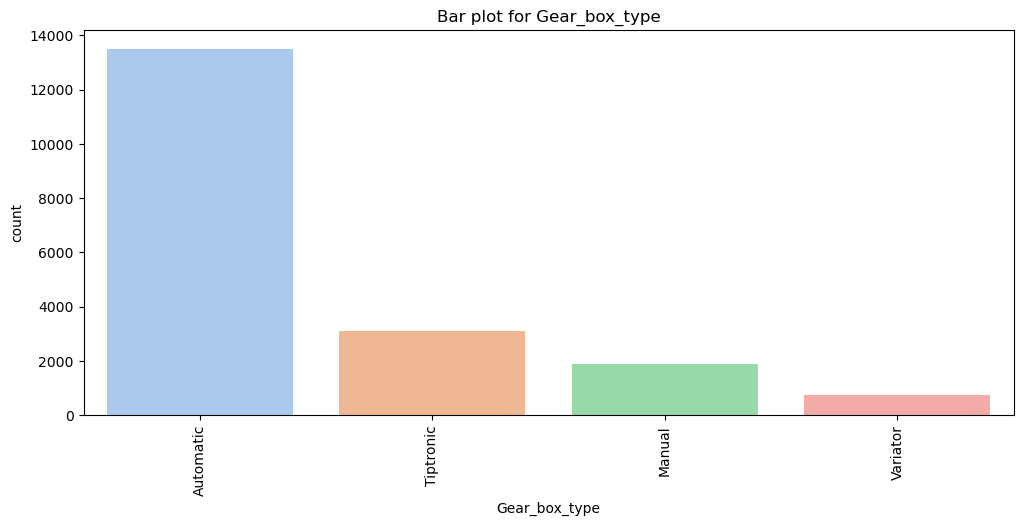

In [272]:
# create a function to draw a barplot for all categorical features
def plot_cat_barplot():
    for cols in categorical_cols:
        plt.figure(figsize=(12,5))
        value = df[cols].value_counts(ascending=False).reset_index()[:20]
        sns.barplot(x=cols, y='count', data=value, hue=cols, palette='pastel')
        plt.xticks(rotation=90)
        plt.title(f'Bar plot for {cols}')
        plt.show();
    
plot_cat_barplot()

Analysis if there is a relationship between some categorical features and prices e.g Leather interior

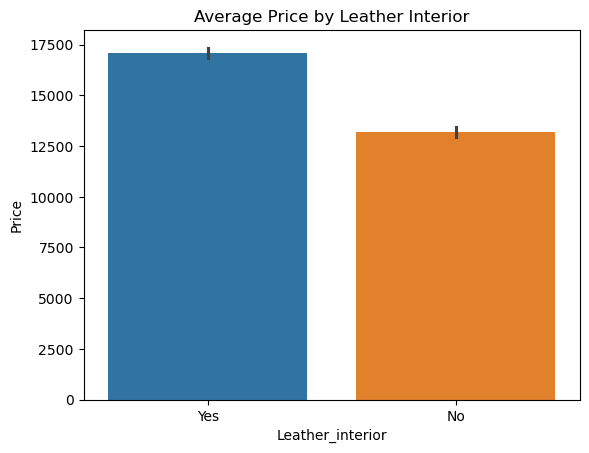

In [273]:
sns.barplot(x='Leather_interior', y='Price', data=df, estimator=np.mean, hue='Leather_interior')
plt.title('Average Price by Leather Interior')
plt.show();

##### Leather interior has a slight impact on the price than non-leather

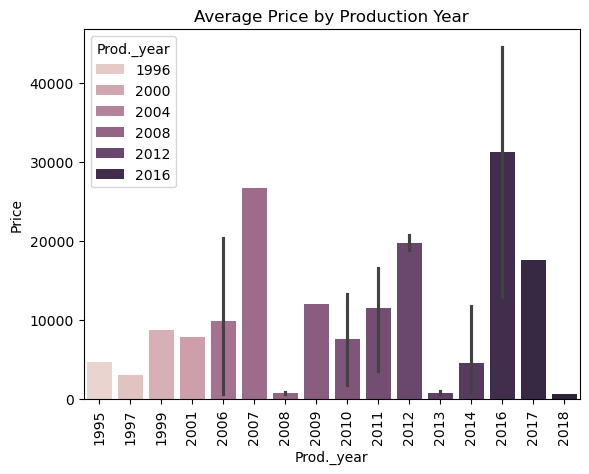

In [274]:

sns.barplot(x='Prod._year', y='Price', data=df.iloc[:30], estimator=np.mean, hue='Prod._year')
plt.title('Average Price by Production Year')
plt.xticks(rotation=90)
plt.show();

##### Advancement in Year does not have a significant impact on the in price

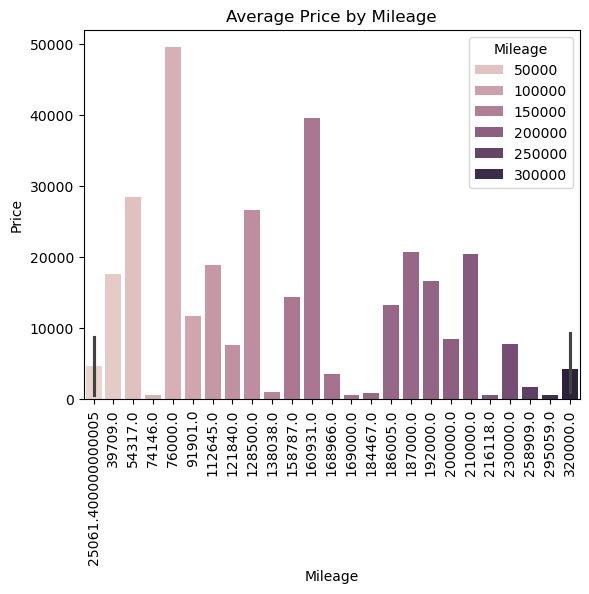

In [275]:
sns.barplot(x='Mileage', y='Price', data=df.iloc[:30], estimator=np.mean, hue='Mileage')
plt.title('Average Price by Mileage')
plt.xticks(rotation=90)
plt.show();

##### There is no sig of mileage to increase in price

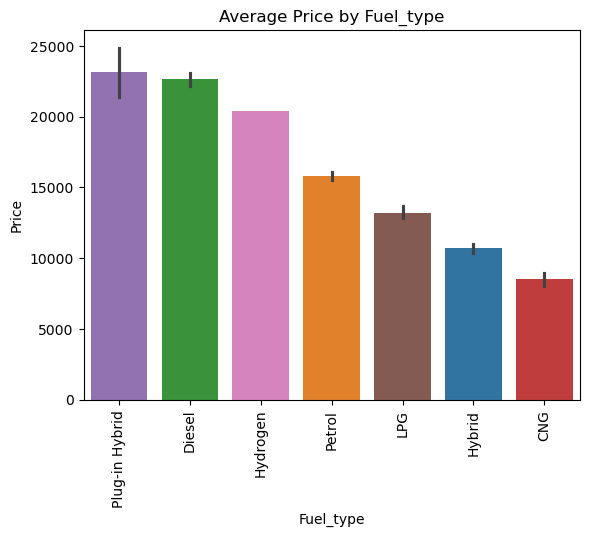

In [276]:
grouped_df = df.groupby('Fuel_type')['Price'].mean()
sorted_order = grouped_df.sort_values(ascending=False).index

sns.barplot(x='Fuel_type', y='Price', data=df, estimator=np.mean, hue='Fuel_type', order=sorted_order)
plt.title('Average Price by Fuel_type')
plt.xticks(rotation=90);
plt.show();

##### It shows that diesel has the highest mean price, next is plug-in Hybrid

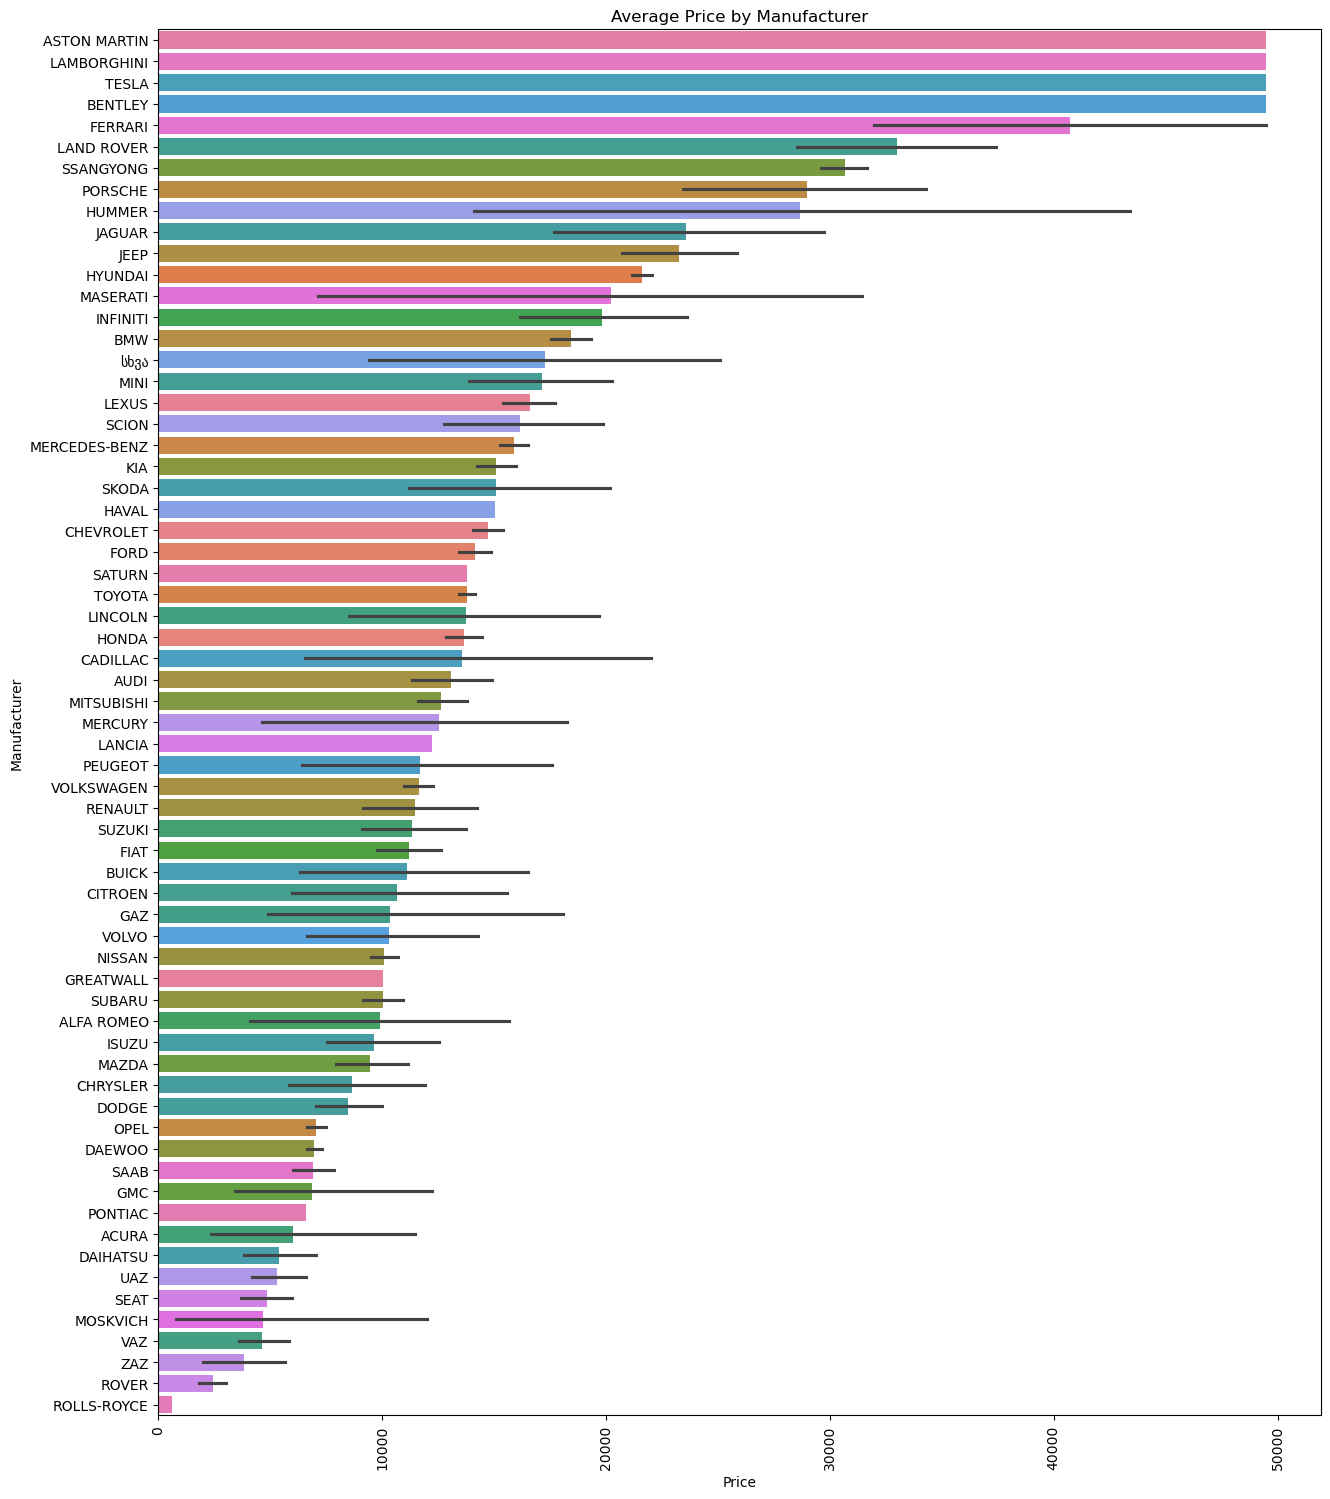

In [277]:
df_subset = df.iloc[:30]
grouped_df = df.groupby('Manufacturer')['Price'].mean()

sorted_order = grouped_df.sort_values(ascending=False).index

plt.figure(figsize=(15,18))
sns.barplot(y='Manufacturer', x='Price', data=df, estimator=np.mean, hue='Manufacturer',order=sorted_order)
plt.title('Average Price by Manufacturer')
plt.xticks(rotation=90)
plt.show();

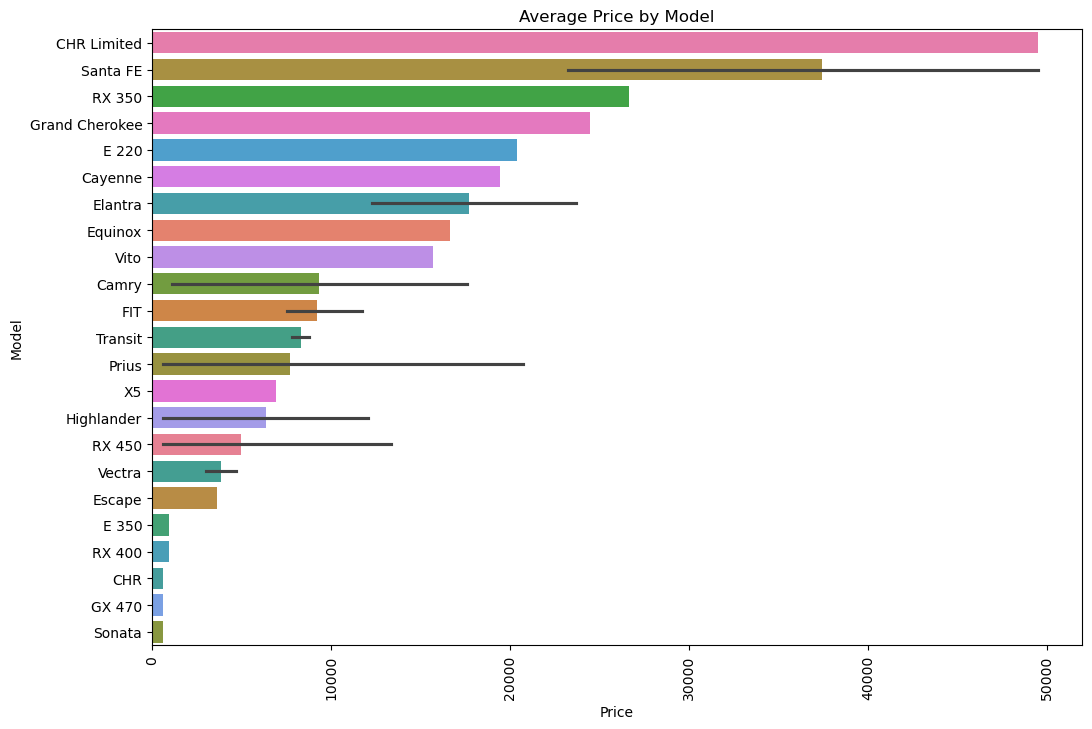

In [278]:
df_subset = df.iloc[:40]
grouped_df = df_subset.groupby('Model')['Price'].mean()

sorted_order = grouped_df.sort_values(ascending=False).index

plt.figure(figsize=(12,8))
sns.barplot(y='Model', x='Price', data=df_subset, estimator=np.mean, hue='Model',order=sorted_order)
plt.title('Average Price by Model')
plt.xticks(rotation=90)
plt.show();

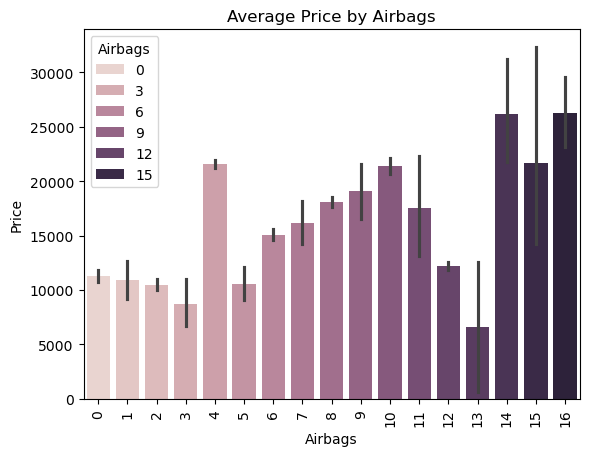

In [279]:
sns.barplot(x='Airbags', y='Price', data=df, estimator=np.mean, hue='Airbags')
plt.title('Average Price by Airbags')
plt.xticks(rotation=90);
plt.show()

##### In the no of airbags, there is a small impact in the number of airbags to the price

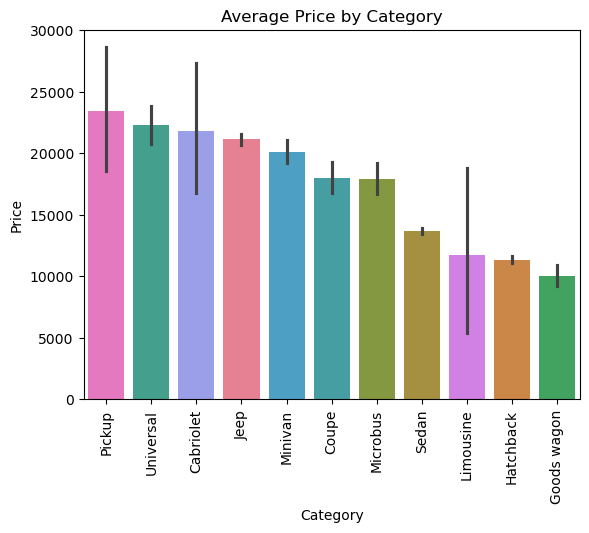

In [280]:
subset_df = df.iloc[:30]
grouped_df = df.groupby('Category')['Price'].mean()
sorted_order = grouped_df.sort_values(ascending=False).index

sns.barplot(data=df, x='Category', y='Price', estimator=np.mean, hue="Category", order=sorted_order)
plt.title('Average Price by Category')
plt.xticks(rotation=90);
plt.show();

##### The category has influence on the price

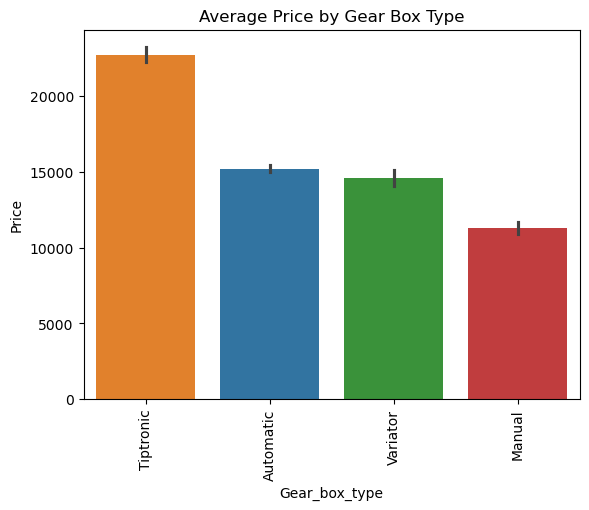

In [281]:
subset_df = df.iloc[:30]
grouped_df = df.groupby('Gear_box_type')['Price'].mean()
sorted_order = grouped_df.sort_values(ascending=False).index

sns.barplot(data=df, x='Gear_box_type', y='Price', estimator=np.mean, hue="Gear_box_type", order=sorted_order)
plt.title('Average Price by Gear Box Type')
plt.xticks(rotation=90);
plt.show();

Let's create a corr heatmap to see features that are closely related 
Features with a 0.8 corr will dropped in place of that which does not 
have an outlier

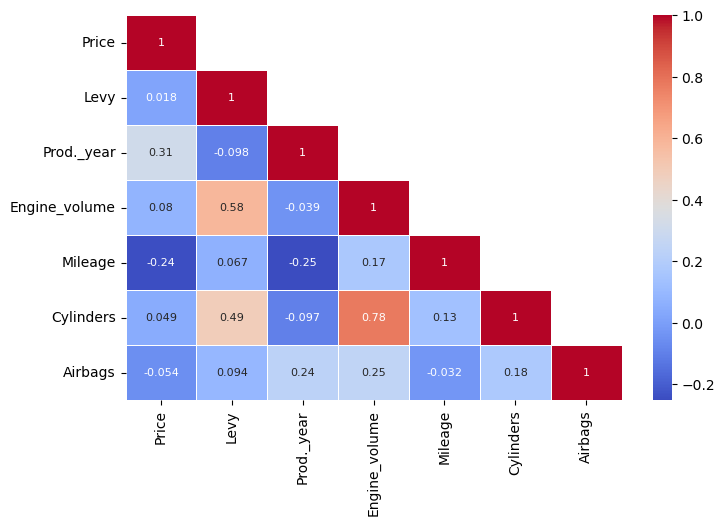

In [282]:
# Corr between numerical cols
corr = df[numerical_cols].corr()
# Remove repetition
plt.figure(figsize=(8,5))
mask = ~np.tri(corr.shape[0], k=0, dtype=bool)

sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', linewidths=0.5, annot_kws={'size': 8});
plt.show();

Let's visualize the relationship between two numerical variables. It is especially useful for identifying correlations, trends, clusters, and potential outliers in data

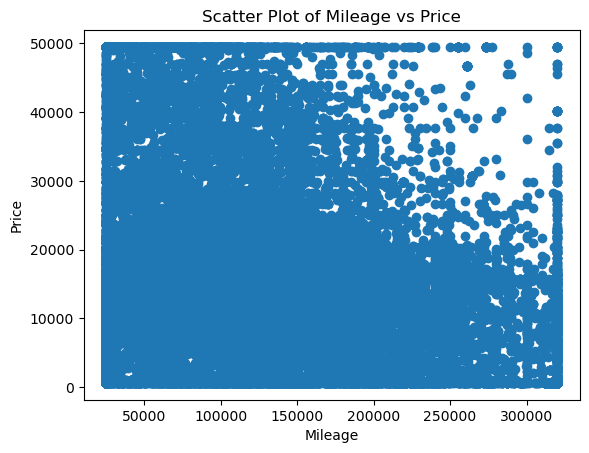

In [283]:
plt.scatter(x=df['Mileage'], y=df['Price'])
plt.xlabel('Mileage')
plt.ylabel('Price')
plt.title('Scatter Plot of Mileage vs Price')
plt.show();

In [239]:
# man_counts = df['Manufacturer'].value_counts()

# # Filter out Models that appear less than 10 times
# df = df[df['Manufacturer'].isin(man_counts[man_counts >= 2].index)]
# df

#### FEATURE ENGINEERING

I want to explicity encode a notion of hgher value(mean) is equal to higher significance

In [284]:
def encoded_cols(cols_to_eng:list):
    for col in cols_to_eng:
        json_name = col+'s'
        mean_price = df.groupby(col)['Price'].mean()
        sorted_col = mean_price.sort_values(ascending=True)
        col_encoding = {column: value+1 for value, column in enumerate(sorted_col.index)}

        col_name = {json_name: col_encoding}

        with open(f'{col}.json', 'w') as file:
            json.dump(col_name, file, indent=4)

        df[col] = df[col].map(col_encoding)

In [285]:
cols_to_eng = ['Manufacturer', 'Model', 'Category', 'Gear_box_type', 'Fuel_type']
encoded_cols(cols_to_eng)

         Price    Levy  Manufacturer  Model  Prod._year  Category  \
0      13328.0  1399.0            48    491        2010         8   
1      16621.0  1018.0            42    421        2011         8   
2       8467.0   906.0            37    592        2006         2   
3       3607.0   862.0            41    392        2011         8   
4      11726.0   583.0            37    592        2014         2   
...        ...     ...           ...    ...         ...       ...   
19232   8467.0   906.0            46    338        1999         6   
19233  15681.0   831.0            54    746        2011         4   
19234  26108.0   836.0            54   1312        2010         8   
19235   5331.0  1288.0            42    941        2007         8   
19236    627.0   753.0            54    746        2012         4   

      Leather_interior  Fuel_type  Engine_volume   Mileage  Cylinders  \
0                  Yes          2            3.5  186005.0          6   
1                   No   

In [286]:
df

,Price,Levy,Manufacturer,Model,Prod._year,Category,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box_type,Airbags
0,13328.0,1399.0,48,491,2010,8,Yes,2,3.5,186005.0,6,3,12
1,16621.0,1018.0,42,421,2011,8,No,4,3.0,192000.0,6,4,8
2,8467.0,906.0,37,592,2006,2,No,4,1.5,200000.0,4,2,2
3,3607.0,862.0,41,392,2011,8,Yes,2,2.5,168966.0,4,3,0
4,11726.0,583.0,37,592,2014,2,Yes,4,1.5,91901.0,4,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19232,8467.0,906.0,46,338,1999,6,Yes,1,2.0,300000.0,4,1,5
19233,15681.0,831.0,54,746,2011,4,Yes,4,2.4,161600.0,4,4,8
19234,26108.0,836.0,54,1312,2010,8,Yes,6,2.0,116365.0,4,3,4
19235,5331.0,1288.0,42,941,2007,8,Yes,6,2.0,51258.0,4,3,4


##### Do the same feature engineering for the model col

In [371]:
"""STANDARDIZATION"""
scaler = StandardScaler()

scaled_data_mileage = scaler.fit_transform(df[['Mileage']])

df.loc[:,'Mileage'] = scaled_data_mileage

In [287]:
le = LabelEncoder()

In [288]:
df['Leather_interior'] = le.fit_transform(df['Leather_interior'])

In [289]:
df

,Price,Levy,Manufacturer,Model,Prod._year,Category,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box_type,Airbags
0,13328.0,1399.0,48,491,2010,8,1,2,3.5,186005.0,6,3,12
1,16621.0,1018.0,42,421,2011,8,0,4,3.0,192000.0,6,4,8
2,8467.0,906.0,37,592,2006,2,0,4,1.5,200000.0,4,2,2
3,3607.0,862.0,41,392,2011,8,1,2,2.5,168966.0,4,3,0
4,11726.0,583.0,37,592,2014,2,1,4,1.5,91901.0,4,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19232,8467.0,906.0,46,338,1999,6,1,1,2.0,300000.0,4,1,5
19233,15681.0,831.0,54,746,2011,4,1,4,2.4,161600.0,4,4,8
19234,26108.0,836.0,54,1312,2010,8,1,6,2.0,116365.0,4,3,4
19235,5331.0,1288.0,42,941,2007,8,1,6,2.0,51258.0,4,3,4


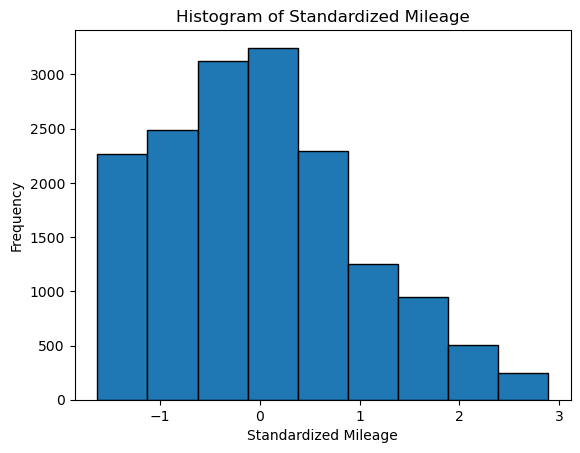

In [372]:
# plot a histogram to showcase the standardized values
plt.hist(df.Mileage, bins=9, edgecolor='black')
plt.xlabel('Standardized Mileage')
plt.ylabel('Frequency')
plt.title('Histogram of Standardized Mileage');
plt.show()

In [373]:
cleaned_df = df.copy()

In [225]:
# Dsplay the Manufacturer, Model against the Category
cat_df = cleaned_df.copy()
cat_df['group'] = cat_df['Manufacturer']
pivot_table = pd.pivot_table(cat_df, columns='Fuel_type', values='Manufacturer', index=['group'], aggfunc='count', fill_value=0)
pivot_table['row_sum'] = pivot_table.sum(axis=1)
pivot_table = pivot_table[['row_sum'] + [col for col in pivot_table.columns if col != 'row_sum']]

pivot_table.sort_values(ascending=False, by='row_sum').head()

Fuel_type,row_sum,CNG,Diesel,Hybrid,LPG,Petrol,Plug-in Hybrid
group,,,,,,,
HYUNDAI,1797,0,594,58,128,1017,0
TOYOTA,1741,7,9,1050,14,653,8
CHEVROLET,670,0,220,37,11,370,32
MERCEDES-BENZ,537,42,237,0,18,240,0
FORD,528,1,131,150,2,228,16


In [374]:
dummies_manu = pd.get_dummies(cleaned_df['Manufacturer'], drop_first=True, dtype=int)
dummies_model = pd.get_dummies(cleaned_df['Model'], drop_first=True, dtype=int)
dummies_fuel_type = pd.get_dummies(cleaned_df['Fuel_type'], drop_first=True, dtype=int)
dummies_gear = pd.get_dummies(cleaned_df['Gear_box_type'], drop_first=True, dtype=int)
dummies_category = pd.get_dummies(cleaned_df['Category'], drop_first=True, dtype=int)


In [375]:
cols_to_encode = ['Manufacturer', 'Model', 'Fuel_type', 'Gear_box_type', "Prod._year", 'Leather_interior', 'Category']
cleaned_df = pd.concat([cleaned_df.drop(columns=cols_to_encode), dummies_manu, dummies_fuel_type, dummies_model, dummies_gear, dummies_category], axis=1)

In [376]:
cleaned_df

,Price,Engine_volume,Mileage,Cylinders,Airbags,Age,AUDI,BMW,BUICK,CADILLAC,...,Coupe,Goods wagon,Hatchback,Jeep,Limousine,Microbus,Minivan,Pickup,Sedan,Universal
0,13328,3.5,0.662577,6,12,14,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,16621,3.0,0.736424,6,8,13,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,8467,1.3,0.834967,4,2,18,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,3607,2.5,0.452691,4,0,13,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,11726,1.3,-0.496594,4,4,10,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19232,8467,2.0,2.066765,4,5,25,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
19233,15681,2.4,0.361957,4,8,13,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
19234,26108,2.0,-0.195247,4,4,14,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
19235,5331,2.0,-0.997233,4,4,17,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [229]:
"""TRAIN TEST SPLIT"""

'TRAIN TEST SPLIT'

In [377]:
X = cleaned_df.drop('Price', axis=1)
y = cleaned_df.Price

In [231]:
# X_scaled = scaler.fit_transform(X)

In [378]:
X

,Engine_volume,Mileage,Cylinders,Airbags,Age,AUDI,BMW,BUICK,CADILLAC,CHEVROLET,...,Coupe,Goods wagon,Hatchback,Jeep,Limousine,Microbus,Minivan,Pickup,Sedan,Universal
0,3.5,0.662577,6,12,14,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,3.0,0.736424,6,8,13,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
2,1.3,0.834967,4,2,18,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,2.5,0.452691,4,0,13,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,1.3,-0.496594,4,4,10,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19232,2.0,2.066765,4,5,25,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
19233,2.4,0.361957,4,8,13,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
19234,2.0,-0.195247,4,4,14,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
19235,2.0,-0.997233,4,4,17,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0


In [379]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [380]:
lr_model = LinearRegression(n_jobs=10)
lr_model.fit(X_train, y_train)

LinearRegression(n_jobs=10)

In [381]:
lr_model.score(X_test, y_test)

-4808316158540278.0

In [382]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

In [399]:
def get_best_model(X,y):
    model_params = {
        'random_forest_reg': {
            'model': RandomForestRegressor(),
            'params': {
                'max_depth': [150],
                'n_estimators': [300],
            }
        },
        # 'xgb_regressor': {
        #     'model': XGBRegressor(objective='reg:squarederror', enable_categorical=True),
        #     'params': {
        #         'n_estimators': [300]
        #     }
        # }
    }
    scores = []
    for model_name, mp in model_params.items():
        gs = GridSearchCV(mp['model'], mp['params'], cv=cv, return_train_score=False)
        gs.fit(X, y)
        scores.append({
            'model_name': model_name,
            'best_params': gs.best_params_,
            'best_score': gs.best_score_
        })
    best_model = pd.DataFrame(scores, columns=['model_name', 'best_params', 'best_score'])
    return best_model

In [400]:
get_best_model(X_train, y_train)

,model_name,best_params,best_score
0,random_forest_reg,"{'max_depth': 150, 'n_estimators': 300}",0.740567


In [238]:
def train_test_cross_validate(model, X_train, y_train, X_test, y_test, cv):
    model.fit(X_train, y_train)
    model_score = model.score(X_test, y_test)
    
    # Train pred
    y_train_pred = model.predict(X_train)
    rmse_train = mean_absolute_error(y_train, y_train_pred)

    # Test Pred
    y_test_pred = model.predict(X_test)
    rmse_test = mean_absolute_error(y_test, y_test_pred)

    # Perform 5-fold cross-validation
    rmse_cv = -cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=cv)

    rmse_cv_mean = np.mean(rmse_cv)

    # Display results
    print(f'Model Score: {model_score:.4f}')
    print(f"Training RMSE: {rmse_train:.4f}")
    print()
    print(f"Initial Test RMSE: {rmse_test:.4f}")
    print()
    print(f"Average Cross-Validation RMSE: {rmse_cv_mean:.4f}")
    print()
    print(f"Cross-Validation Scores: {rmse_cv}\n")
    print()

In [239]:
additional_params = {
    'X_train' : X_train, 
    'y_train' : y_train, 
    'X_test' : X_test, 
    'y_test': y_test, 
    'cv':10}


models = {
    'Xgboost': XGBRegressor(n_estimators=100),
    'Random Forest': RandomForestRegressor(max_depth=10, n_estimators=200),
}

for model_name, model in models.items():
    print(f'{model_name} Regression Model: ')
    print()

    trained_model = train_test_cross_validate(model, **additional_params)

    print(trained_model)

Xgboost Regression Model: 

Model Score: 0.6332
Training RMSE: 2318.8104

Initial Test RMSE: 3082.0947

Average Cross-Validation RMSE: 4160.3490

Cross-Validation Scores: [3869.04257959 4168.56249802 4413.6928061  3989.62533091 4234.62116467
 4180.44015117 4155.17414788 4349.11464872 4214.0755369  4029.14090761]


None
Random Forest Regression Model: 

Model Score: 0.5842
Training RMSE: 2796.3669

Initial Test RMSE: 3355.5226

Average Cross-Validation RMSE: 4406.0292

Cross-Validation Scores: [4096.09446805 4423.63687954 4415.62330923 4346.07888112 4525.48340503
 4570.00750821 4314.74050336 4502.00889588 4503.26467285 4363.35319381]


None
